In [2]:
from cytograph import Algorithm, creates, requires, div0
from cytograph.visualization.scatter import scatterc, scattern
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List
import shoji
import cytograph as cg
import cytograph.visualization as cgplot
import collections
from typing import List, Optional
import matplotlib.patheffects as PathEffects
import fastcluster
import igraph
import leidenalg as la
import scipy.cluster.hierarchy as hc
from hmmlearn import hmm
from openTSNE import TSNE
from pynndescent import NNDescent
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from tqdm import trange
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from cytograph.visualization import Colorizer
from matplotlib.lines import Line2D
import scipy as sci
import scanpy as sc

In [3]:
db = shoji.connect()

In [4]:
ws = db.builds.jesper.GBM_all.SL040

In [5]:
ws

Workspace with 0 workspaces, 8 dimensions and 106 tensors:
  annotations <Dimension of shape 67>
  cells <Dimension of shape 135482>
  clusters <Dimension of shape 30>
  genes <Dimension of shape 59480>
  karyotype_genes <Dimension of shape 6558>
  karyotype_metacells <Dimension of shape 21>
  karyotype_windows <Dimension of shape 6558>
  signatures <Dimension of shape 1>
  Accession <Tensor Accession dtype='string' dims=('genes',), shape=(59480,), chunks=(15,)>
  Accession_copy <Tensor Accession_copy dtype='string' dims=('genes',), shape=(59480,), chunks=(15,)>
  Age <Tensor Age dtype='float32' dims=('cells',), shape=(135482,), chunks=(125,)>
  AneuploidMeta <Tensor AneuploidMeta dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  AneuploidMeta2 <Tensor AneuploidMeta2 dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Aneuploid_Manual <Tensor Aneuploid_Manual dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Aneuploid_expression <Tensor Aneuploid_expression dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  AnnotationDefinition <Tensor AnnotationDefinition dtype='string' dims=('annotations',), shape=(67,), chunks=(15,)>
  AnnotationDescription <Tensor AnnotationDescription dtype='string' dims=('annotations',), shape=(67,), chunks=(15,)>
  AnnotationName <Tensor AnnotationName dtype='string' dims=('annotations',), shape=(67,), chunks=(15,)>
  AnnotationPosterior <Tensor AnnotationPosterior dtype='float32' dims=('clusters', 'annotations'), shape=(30, 67), chunks=(75, 100)>
  CellCycleFraction <Tensor CellCycleFraction dtype='float32' dims=('cells',), shape=(135482,), chunks=(125,)>
  CellID <Tensor CellID dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Celltype <Tensor Celltype dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Chemistry <Tensor Chemistry dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Chromosome <Tensor Chromosome dtype='string' dims=('genes',), shape=(59480,), chunks=(15,)>
  Clones <Tensor Clones dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Clones2 <Tensor Clones2 dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  ClonesAbberations <Tensor ClonesAbberations dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  ClonesAbberations2 <Tensor ClonesAbberations2 dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  ClusterID <Tensor ClusterID dtype='uint32' dims=('clusters',), shape=(30,), chunks=(125,)>
  Clusters <Tensor Clusters dtype='uint32' dims=('cells',), shape=(135482,), chunks=(125,)>
  ClustersProbability <Tensor ClustersProbability dtype='float32' dims=('cells',), shape=(135482,), chunks=(125,)>
  ClustersSecondary <Tensor ClustersSecondary dtype='uint32' dims=('cells',), shape=(135482,), chunks=(125,)>
  ClustersSecondaryProbability <Tensor ClustersSecondaryProbability dtype='float32' dims=('cells',), shape=(135482,), chunks=(125,)>
  Direction <Tensor Direction dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Dissociation <Tensor Dissociation dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  Donor <Tensor Donor dtype='string' dims=('cells',), shape=(135482,), chunks=(15,)>
  DoubletFlag <Tensor DoubletFlag dtype='bool' dims=('cells',), shape=(135482,), chunks=(500,)>
  DoubletScore <Tensor DoubletScore dtype='float32' dims=('cells',), shape=(135482,), chunks=(125,)>
  Embedding <Tensor Embedding dtype='float32' dims=('cells', 2), shape=(135482, 2), chunks=(75, 2)>
  End <Tensor End dtype='string' dims=('genes',), shape=(59480,), chunks=(15,)>
  Enrichment <Tensor Enrichment dtype='float32' dims=('clusters', 'genes'), shape=(30, 59480), chunks=(75, 100)>
  Expression <Tensor Expression dtype='uint16' dims=('cells', 'genes'), shape=(135482, 59480), chunks=(150, 100)>
  Factors <Tensor Factors dtype='float32' dims=('cells', None), shape=(135482, 50), chunks=(75, 100)>
  Fluorescence <Tensor Fluorescence dtype='string

In [4]:
adata = ws.create_anndata()

In [5]:
adata.var = adata.var.set_index('Gene')

In [6]:
adata.var.index = adata.var.index.astype('object')

In [7]:
adata.var_names_make_unique()

In [8]:
adata.var.index.is_unique

True

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata, base=2)

In [11]:
celltype = ['Astrocytes', 'Oligodendrocytes', 'Tumor','TAM','Monocytes']

In [13]:
samples = ['Necrotic core', 'High','Low']

                                      Astrocytes


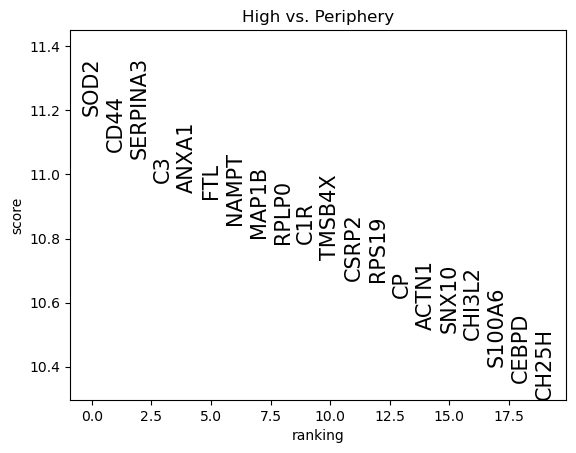

                                      Astrocytes


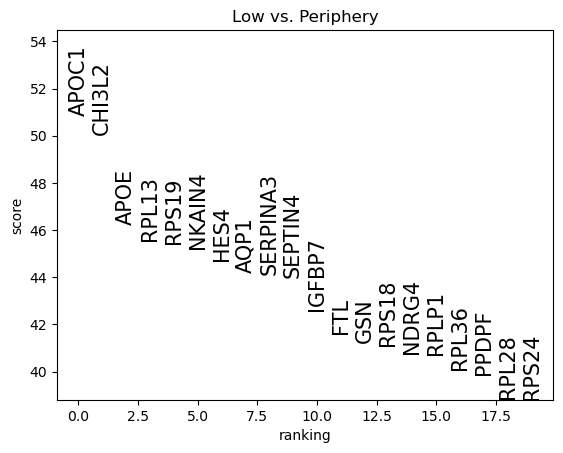

                                      Oligodendrocytes


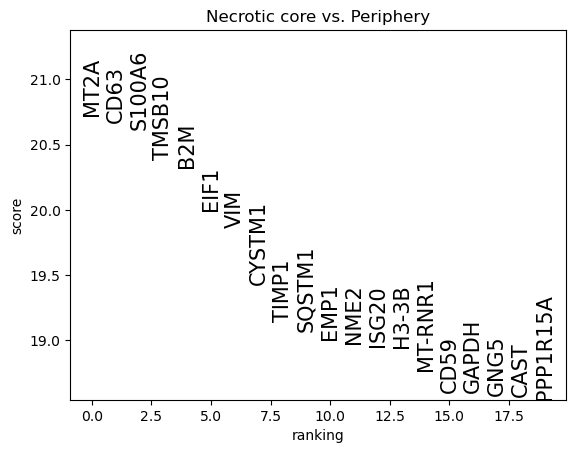

                                      Oligodendrocytes


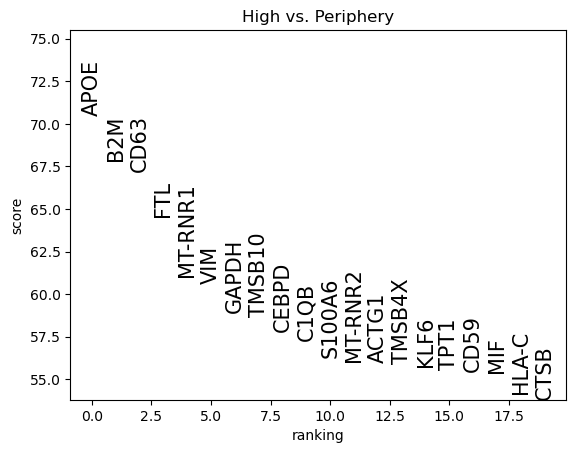

                                      Oligodendrocytes


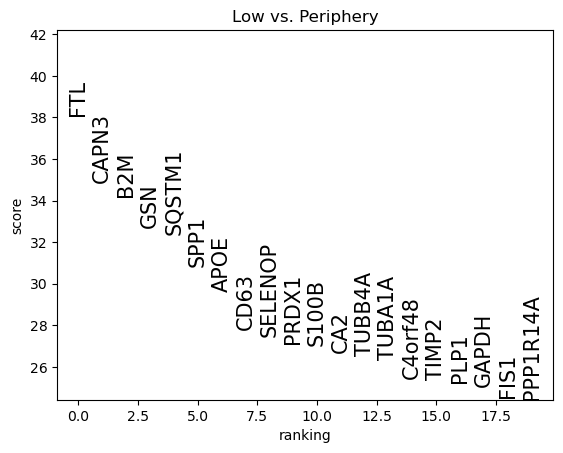

                                      Tumor


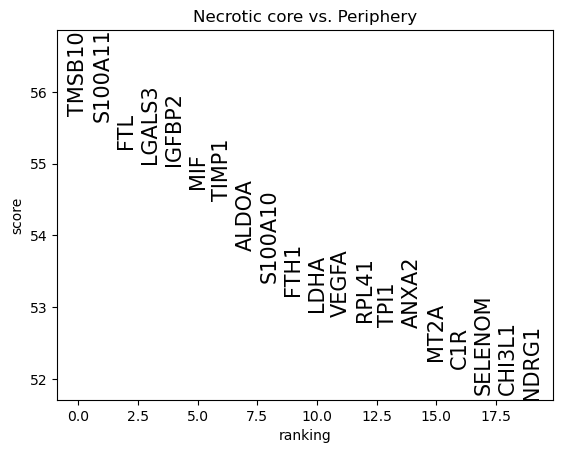

                                      Tumor


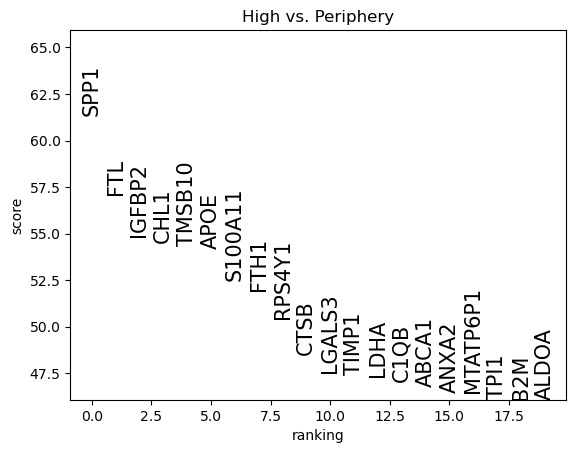

                                      Tumor


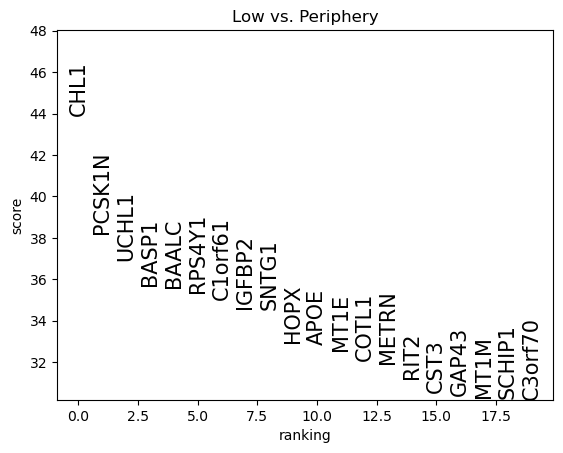

                                      TAM


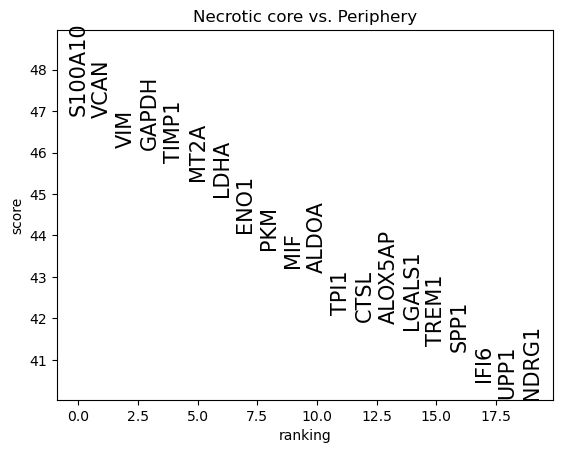

                                      TAM


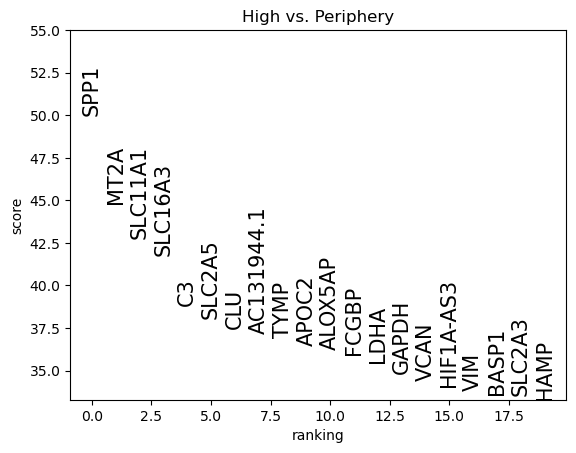

                                      TAM


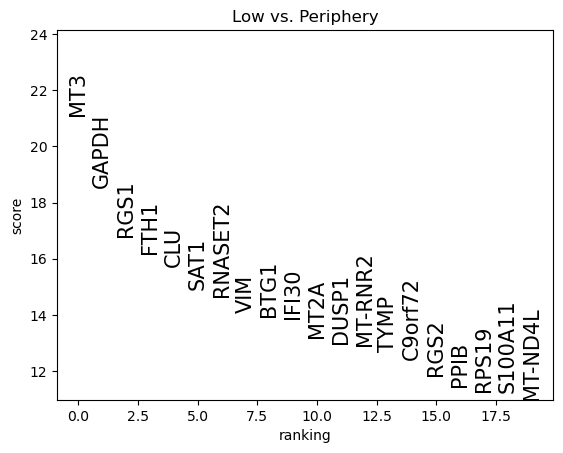

                                      Monocytes


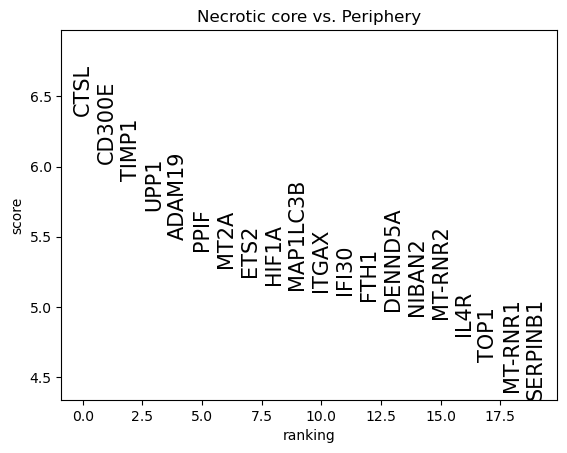

                                      Monocytes


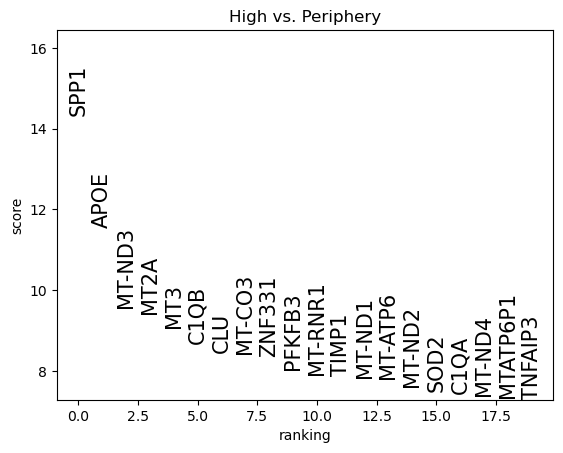

                                      Monocytes


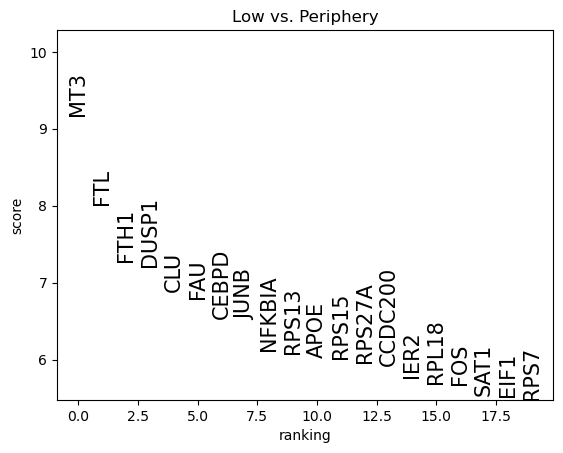

In [16]:
for cell in celltype:
    cells = adata[adata.obs['ManualAnnotationSL040_TAM'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.ManualAnnotationSL040_TAM[ws.Zone[:] == sample] == cell)
        if Su > 10:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        print('                                      ' + cell)
        sc.pl.rank_genes_groups(cells, groups=[samp], n_genes=20, fontsize=15) 

In [17]:
gene_list = np.array(['CHI3L1', 'ANXA2', 'ANXA1', 'CD44', 'VIM', 'MT2A', 'C1S', 'NAMPT',
       'EFEMP1', 'C1R', 'SOD2', 'IFITM3', 'TIMP1', 'SPP1', 'A2M',
       'S100A11', 'MT1X', 'S100A10', 'FN1', 'LGALS1', 'S100A16', 'CLIC1',
       'MGST1', 'RCAN1', 'TAGLN2', 'NPC2', 'SERPING1', 'TCIM', 'EMP1',
       'APOE', 'CTSB', 'C3', 'LGALS3', 'MT1E', 'EMP3', 'SERPINA3',
       'ACTN1', 'PRDX6', 'IGFBP7', 'SERPINE1', 'PLP2', 'MGP', 'CLIC4',
       'GFPT2', 'GSN', 'NNMT', 'TUBA1C', 'GJA1', 'TNFRSF1A', 'WWTR1',
       'HILPDA', 'ADM', 'DDIT3', 'NDRG1', 'HERPUD1', 'DNAJB9', 'TRIB3',
       'ENO2', 'AKAP12', 'SQSTM1', 'ATF3', 'NRN1', 'SLC2A1', 'BNIP3',
       'INSIG2', 'IGFBP3', 'PPP1R15A', 'PLOD2', 'GBE1', 'SLC2A3', 'FTL',
       'WARS1', 'ERO1A', 'XPOT', 'HSPA5', 'GDF15', 'EPAS1', 'LDHA',
       'P4HA1', 'SERTAD1', 'PFKP', 'PGK1', 'EGLN3', 'SLC6A6', 'CA9',
       'BNIP3L', 'RPL21', 'TRAM1', 'UFM1', 'ASNS', 'GOLT1B', 'ANGPTL4',
       'SLC39A14', 'CDKN1A', 'HSPA9'])

In [20]:
celltype = ['Tumor','TAM','Astrocytes','Oligodendrocytes','Monocytes']

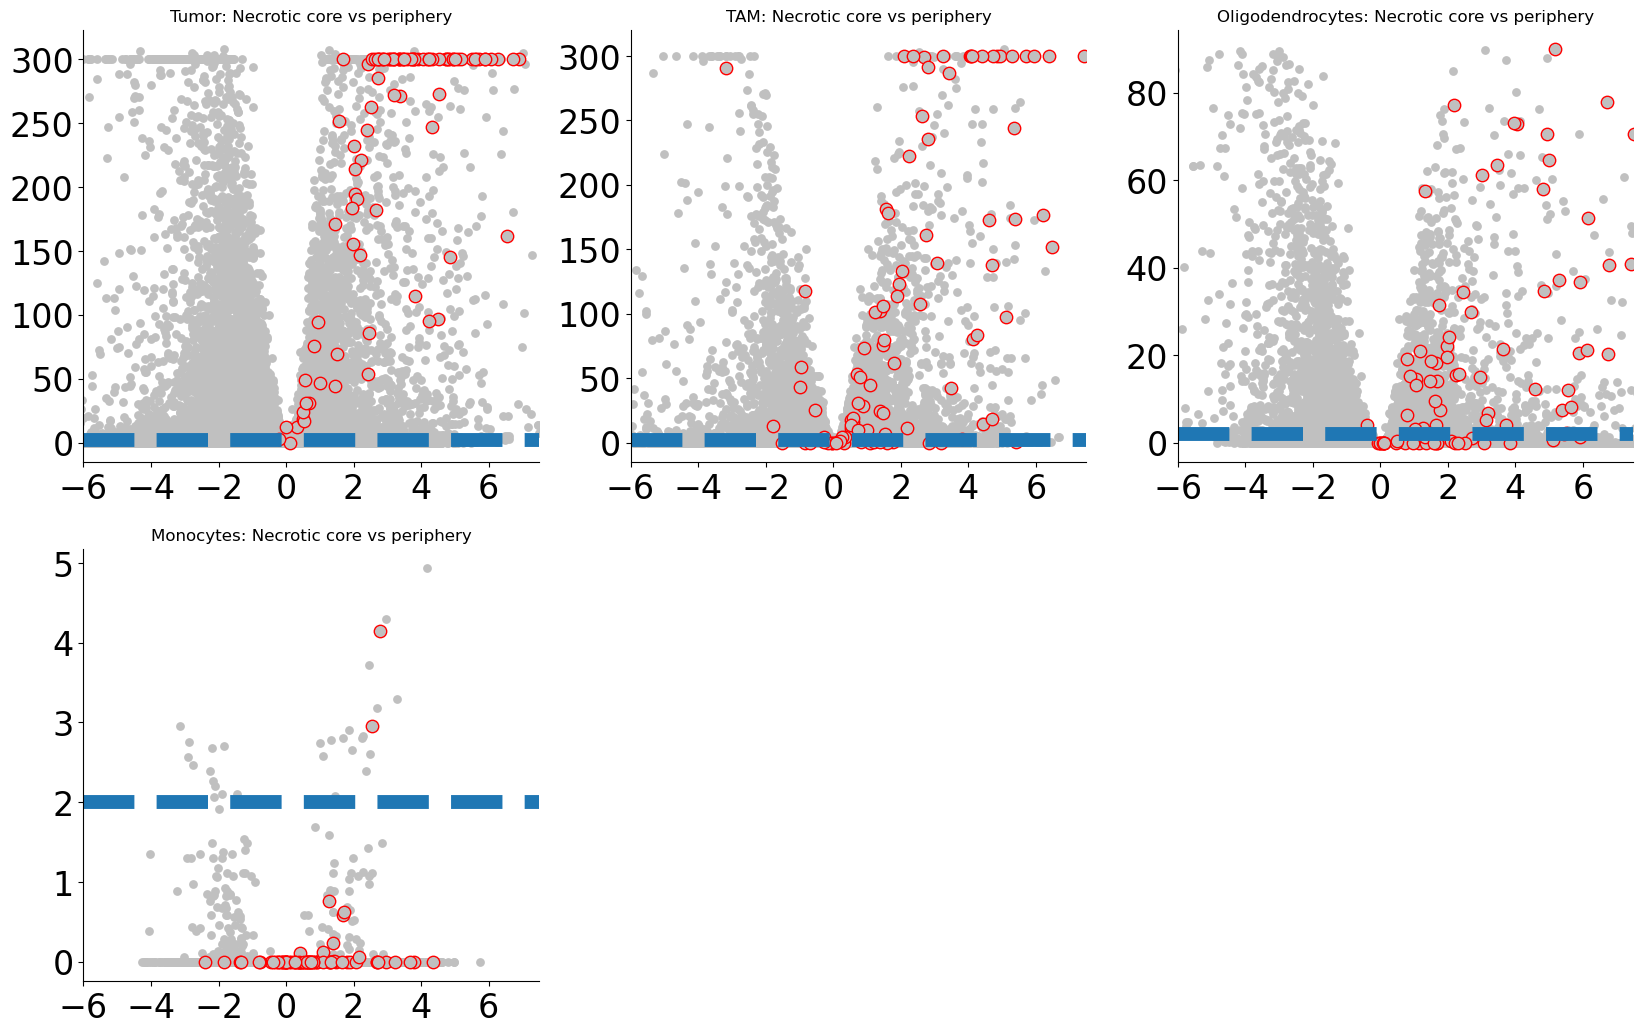

In [25]:
#celltype = np.unique(ws.ManualAnnotationSL040[:])
samples = ['Necrotic core']
#samples = ['High']
#samples = ['Low']
plt.figure(None, (20, 100))
gs = plt.GridSpec(15, 3)
i = 0
for cell in celltype:
    cells = adata[adata.obs['ManualAnnotationSL040_TAM'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.ManualAnnotationSL040_TAM[ws.Zone[:] == sample] == cell)
        if Su > 10:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        gene_rank = sc.get.rank_genes_groups_df(cells, group=samp)[['names','logfoldchanges','pvals', 'pvals_adj']]
        ax = plt.subplot(gs[i])
        x = gene_rank['logfoldchanges']
        y = np.copy(gene_rank['pvals_adj'])
        # setting to less than 1e-300 makes np.log10 inf
        y[y == 0] = 1e-300
        y = -np.log10(y)
        plt.scatter(x, y, s=40, lw=0, color='silver')
        plt.hlines(-np.log10(1e-2), -6, 7.5, linestyles='dashed', lw=10)
        #for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
        for g in gene_list:
            ix = gene_rank['names'] == g
            plt.scatter(x[ix], y[ix], s=80, lw=1, color='silver', edgecolors='r')
            #plt.text(x[ix], y[ix], g, fontsize=8, rotation=30, clip_on=True)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        plt.xlim(-6, 7.5)
        #plt.ylim(0, np.percentile(y, 99.9))
        #plt.ylabel("-log10(P value)",fontsize=24)
        #plt.xlabel("log-fold change", fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.title(cell + ": " + samp + ' vs periphery')
        i += 1
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Volcano_" + cell + "_" + samp + "_40.pdf",dpi=300, bbox_inches="tight")

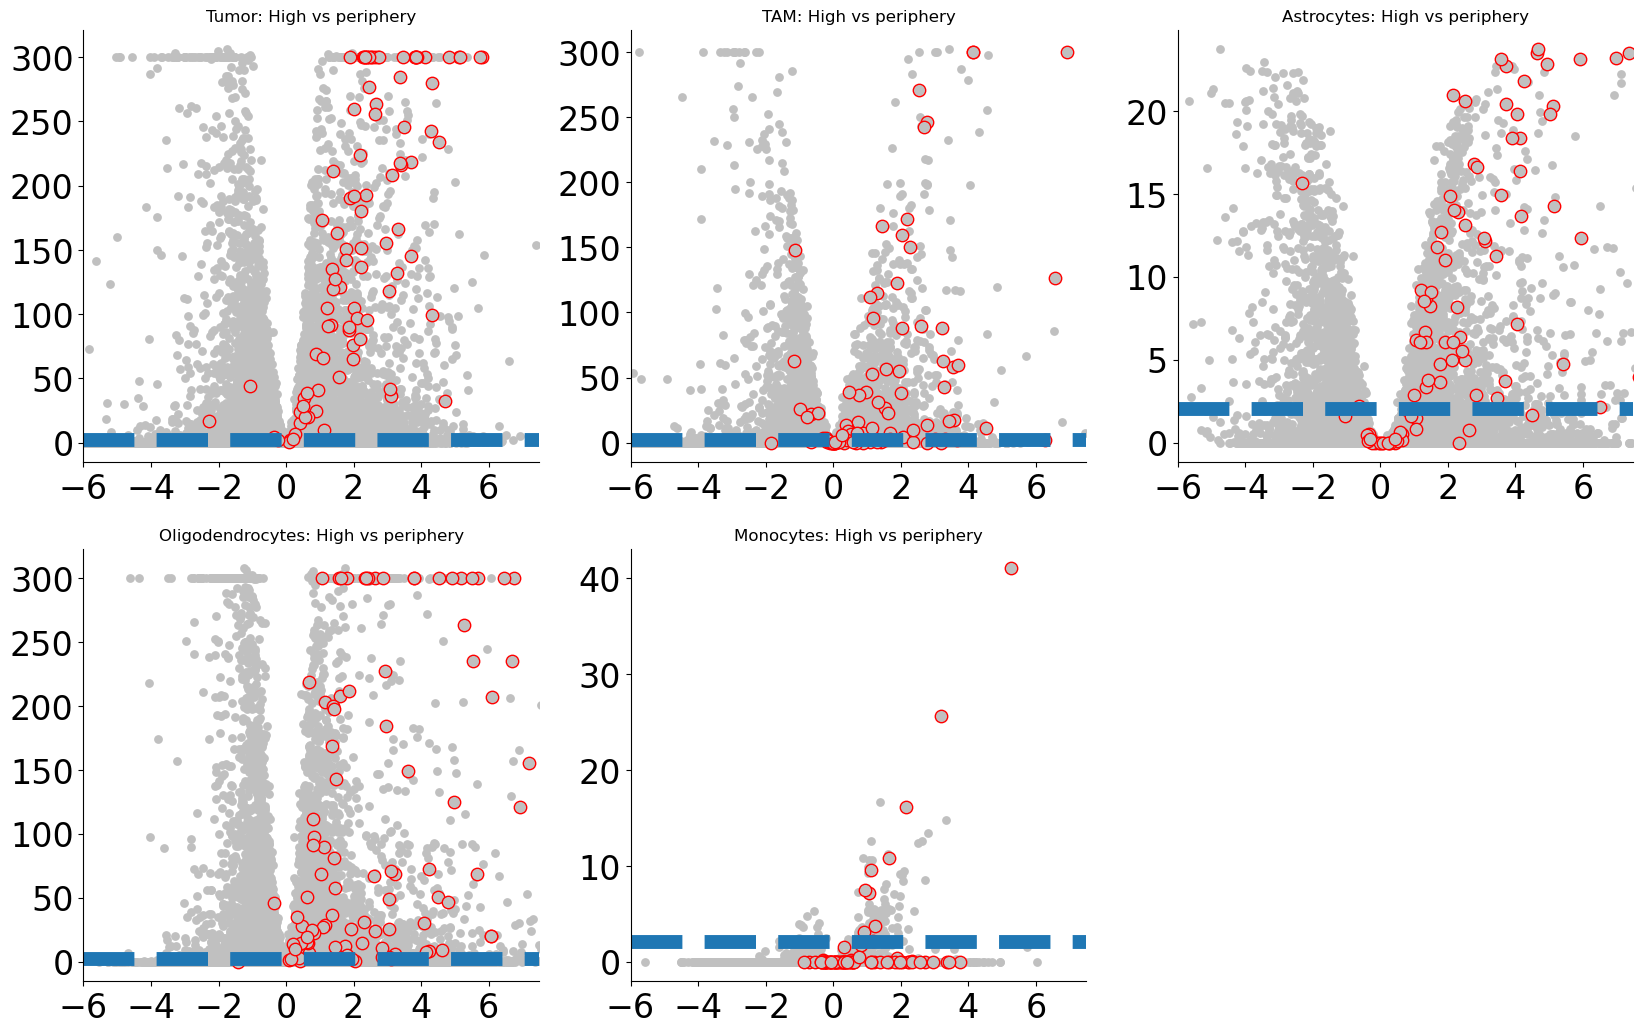

In [23]:
#celltype = np.unique(ws.ManualAnnotationSL040[:])
#samples = ['Necrotic core']
samples = ['High']
#samples = ['Low']
plt.figure(None, (20, 100))
gs = plt.GridSpec(15, 3)
i = 0
for cell in celltype:
    cells = adata[adata.obs['ManualAnnotationSL040_TAM'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.ManualAnnotationSL040_TAM[ws.Zone[:] == sample] == cell)
        if Su > 0:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        gene_rank = sc.get.rank_genes_groups_df(cells, group=samp)[['names','logfoldchanges','pvals', 'pvals_adj']]
        ax = plt.subplot(gs[i])
        x = gene_rank['logfoldchanges']
        y = np.copy(gene_rank['pvals_adj'])
        # setting to less than 1e-300 makes np.log10 inf
        y[y == 0] = 1e-300
        y = -np.log10(y)
        plt.scatter(x, y, s=40, lw=0, color='silver')
        plt.hlines(-np.log10(1e-2), -6, 7.5, linestyles='dashed', lw=10)
        #for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
        for g in gene_list:
            ix = gene_rank['names'] == g
            plt.scatter(x[ix], y[ix], s=80, lw=1, color='silver', edgecolors='r')
            #plt.text(x[ix], y[ix], g, fontsize=8, rotation=30, clip_on=True)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        plt.xlim(-6, 7.5)
        #plt.ylim(0, np.percentile(y, 99.9))
        #plt.ylabel("-log10(P value)",fontsize=24)
        #plt.xlabel("log-fold change", fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.title(cell + ": " + samp + ' vs periphery')
        i += 1
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Volcano_" + cell + "_" + samp + "_40.pdf",dpi=300, bbox_inches="tight")

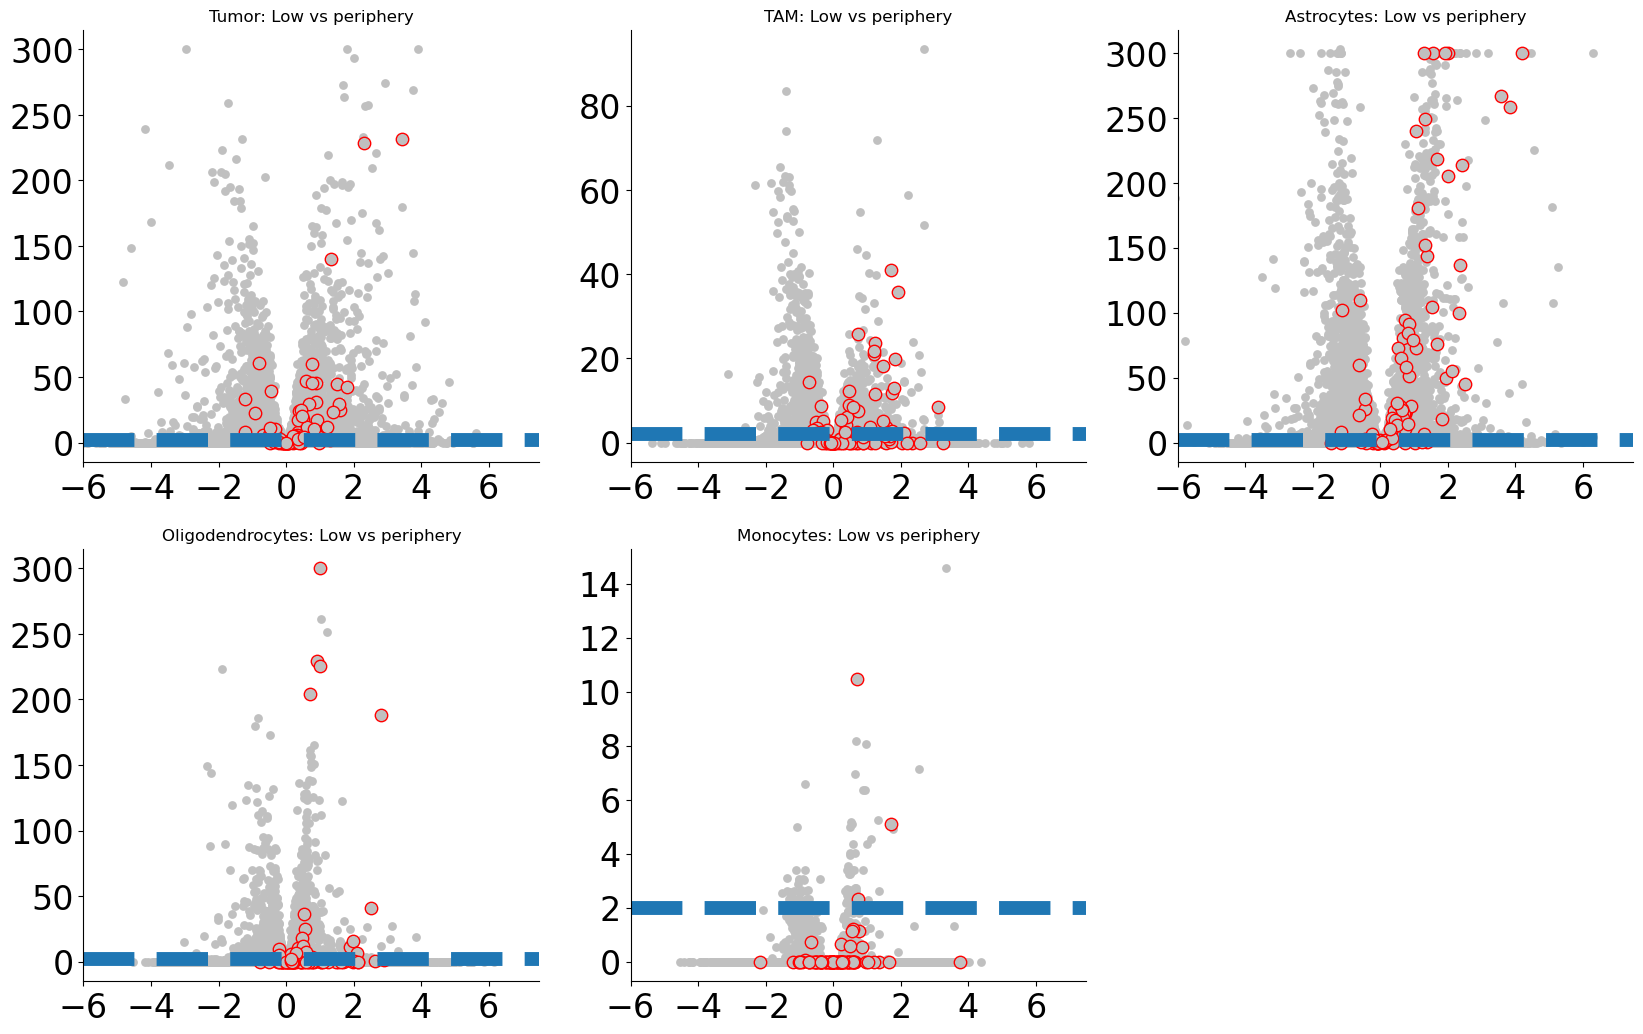

In [24]:
#celltype = np.unique(ws.ManualAnnotationSL040[:])
#samples = ['Necrotic core']
#samples = ['High']
samples = ['Low']
plt.figure(None, (20, 100))
gs = plt.GridSpec(15, 3)
i = 0
for cell in celltype:
    cells = adata[adata.obs['ManualAnnotationSL040_TAM'] == cell,:]
    unique_samples = []
    for sample in samples:
        Su = np.sum(ws.ManualAnnotationSL040_TAM[ws.Zone[:] == sample] == cell)
        if Su > 0:
            unique_samples.append(sample)
    for samp in unique_samples:
        sc.tl.rank_genes_groups(cells, 'Zone', groups=[samp], reference='Periphery', method="wilcoxon")
        gene_rank = sc.get.rank_genes_groups_df(cells, group=samp)[['names','logfoldchanges','pvals', 'pvals_adj']]
        ax = plt.subplot(gs[i])
        x = gene_rank['logfoldchanges']
        y = np.copy(gene_rank['pvals_adj'])
        # setting to less than 1e-300 makes np.log10 inf
        y[y == 0] = 1e-300
        y = -np.log10(y)
        plt.scatter(x, y, s=40, lw=0, color='silver')
        plt.hlines(-np.log10(1e-2), -6, 7.5, linestyles='dashed', lw=10)
        #for g in ['HES1', 'IRX5', 'LHX2', 'NELL1', 'PAX3']:
        for g in gene_list:
            ix = gene_rank['names'] == g
            plt.scatter(x[ix], y[ix], s=80, lw=1, color='silver', edgecolors='r')
            #plt.text(x[ix], y[ix], g, fontsize=8, rotation=30, clip_on=True)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        plt.xlim(-6, 7.5)
        #plt.ylim(0, np.percentile(y, 99.9))
        #plt.ylabel("-log10(P value)",fontsize=24)
        #plt.xlabel("log-fold change", fontsize=24)
        plt.xticks(fontsize=24)
        plt.yticks(fontsize=24)
        plt.title(cell + ": " + samp + ' vs periphery')
        i += 1
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Volcano_" + cell + "_" + samp + "_40.pdf",dpi=300, bbox_inches="tight")